In [1]:
%matplotlib inline
# Scientific computing
import numpy as np

# Data frames (R-style)
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
# Read data
train_data = pd.read_csv('./train.csv')

train_data, test_data = train_test_split(train_data, test_size = 0.2)
test_y = test_data.Survived
test_data.drop('Survived', axis=1, inplace=True)

train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.6500,E67,S
197,198,0,3,"Olsen, Mr. Karl Siegwart Andreas",male,42.0,0,1,4579,8.4042,NaN,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S
334,335,1,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,NaN,S
129,130,0,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S
841,842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.5000,NaN,S
864,865,0,2,"Gill, Mr. John William",male,24.0,0,0,233866,13.0000,NaN,S
671,672,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S
819,820,0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.9000,NaN,S
817,818,0,2,"Mallet, Mr. Albert",male,31.0,1,1,S.C./PARIS 2079,37.0042,NaN,C


In [4]:
train_data.info()
print("--------------")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 558 to 615
Data columns (total 12 columns):
PassengerId    712 non-null int64
Survived       712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            570 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Cabin          154 non-null object
Embarked       710 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB
--------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 195 to 242
Data columns (total 11 columns):
PassengerId    179 non-null int64
Pclass         179 non-null int64
Name           179 non-null object
Sex            179 non-null object
Age            144 non-null float64
SibSp          179 non-null int64
Parch          179 non-null int64
Ticket         179 non-null object
Fare          

We hebben dus 891 entries. De meeste data lijkt compleet, maar bij leeftijd missen er een aantal waardes. Voor test is dit hetzelfde, maar mist er ook een fare waarde.

In [5]:
grouped = train_data.groupby('Survived')
grouped.count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,437,437,437,437,336,437,437,437,437,49,437
1,275,275,275,275,234,275,275,275,275,105,273


Als we de data groeperen op onze doel-variabele, zien we dat de klassen redelijk gebalanceerd zijn.

We hebben dus redelijk gebalanceerde aantallen over de doel-variabele en de data is ook vrij goed (weinig missende getallen).

Wel hebben we een aantal categoriën die minder zeggen (naam, id, kaartnummer, waar ze ingestapt zijn). Deze variabelen kunnen we uit de set gooien.

Daarna moeten we de NAN's in de age kolom nog aanpakken. 

We gaan er hier even van uit dat dit hetzelfde is voor de test data.

In [6]:
train_data.drop(['PassengerId','Name','Ticket','Cabin','Embarked'], axis=1, 
                inplace=True)
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
train_data.Age = train_data.Age.round(decimals=0)
train_data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
558,1,1,female,39.0,1,1,79.6500
197,0,3,male,42.0,0,1,8.4042
271,1,3,male,25.0,0,0,0.0000
334,1,1,female,29.0,1,0,133.6500
129,0,3,male,45.0,0,0,6.9750
841,0,2,male,16.0,0,0,10.5000
864,0,2,male,24.0,0,0,13.0000
671,0,1,male,31.0,1,0,52.0000
819,0,3,male,10.0,3,2,27.9000
817,0,2,male,31.0,1,1,37.0042


In [7]:
test_data.drop(['PassengerId','Name','Ticket','Cabin','Embarked'], axis=1, 
               inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(), inplace=True)
test_data.Age = test_data.Age.round(decimals=0)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 195 to 242
Data columns (total 6 columns):
Pclass    179 non-null int64
Sex       179 non-null object
Age       179 non-null float64
SibSp     179 non-null int64
Parch     179 non-null int64
Fare      179 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 9.8+ KB


Als laatste voorbereiding maken we van een aantal variablen categorische variabelen.

In [8]:
#train_data.Pclass = train_data.Pclass.astype('category')
#train_data.Sex = train_data.Sex.astype('category')
train_data['Sex'] = np.where(train_data['Sex'] == 'female', 1, 0)

#test_data.Pclass = test_data.Pclass.astype('category')
#test_data.Sex = test_data.Sex.astype('category')
test_data['Sex'] = np.where(test_data['Sex'] == 'female', 1, 0)
test_data.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare
195,1,1,58.0,0,0,146.5208
809,1,1,33.0,1,0,53.1000
418,2,0,30.0,0,0,13.0000
8,3,1,27.0,0,2,11.1333
848,2,0,28.0,0,1,33.0000
710,1,1,24.0,0,0,49.5042
463,2,0,48.0,0,0,13.0000
759,1,1,33.0,0,0,86.5000
701,1,0,35.0,0,0,26.2875
313,3,0,28.0,0,0,7.8958


Nu kunnen we gaan kijken naar de data

Survived    1.000000
Pclass     -0.342929
Sex         0.535751
Age        -0.100243
SibSp      -0.008288
Parch       0.101897
Fare        0.270104
Name: Survived, dtype: float64


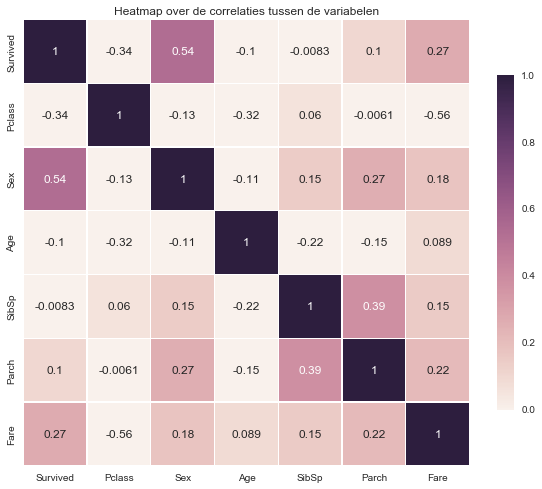

In [9]:
correlations = train_data.corr()
print(correlations['Survived'])

plt.figure(figsize=(10,10))
sns.heatmap(correlations,linewidths=0.25, square=True, 
            cbar_kws={'shrink' : .6}, annot=True, vmin=0, vmax=1)
plt.title("Heatmap over de correlaties tussen de variabelen")

Het lijkt er op dat er niet veel variabelen zijn die sterk met elkaar gecorreleerd zijn. Hier hoeven we dus niet veel voorwerk te doen.

Laten we als laatste eens kijken naar hoe de variabelen onderling verdeeld zijn. 

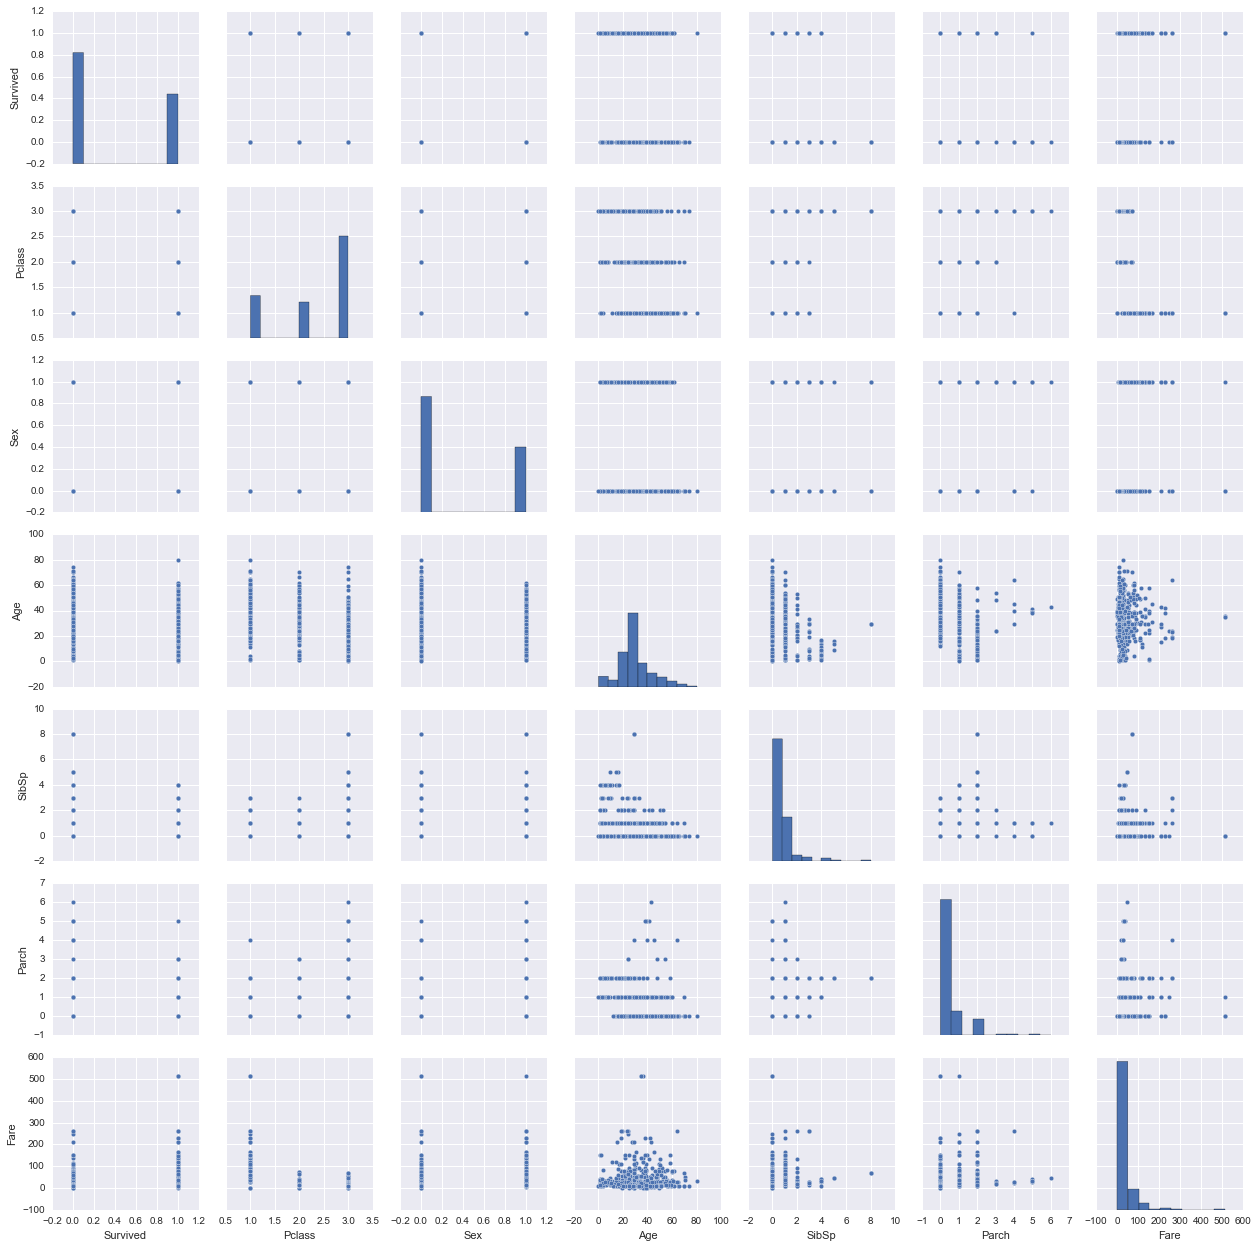

In [10]:
sns.pairplot(train_data)

In [11]:
# Train the model 
train_x = train_data.drop('Survived', axis=1, inplace=False)
train_y = train_data.Survived

classifier = tree.DecisionTreeClassifier()
classifier.fit(train_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [12]:
# Check score on training set
cm_train = confusion_matrix(train_y, classifier.predict(train_x))
auc_train = roc_auc_score(train_y, classifier.predict(train_x))
f1_train = f1_score(train_y, classifier.predict(train_x))
print(cm_train)
print('------------------------------')
print('AUC      : {}'.format(auc_train))
print('F1 Score : {}'.format(f1_train))

[[436   1]
 [ 11 264]]
------------------------------
AUC      : 0.97885583524
F1 Score : 0.977777777778


In [13]:
# Create predictions on the test set
predictions = classifier.predict(test_data)

In [14]:
# Score on the test outcomes
cm_test = confusion_matrix(test_y, predictions)
f1_test = f1_score(test_y, predictions)
auc_test = roc_auc_score(test_y, predictions)
print(cm_test)
print('------------------------------')
print('AUC      : {}'.format(auc_test))
print('F1 Score : {}'.format(f1_test))

[[89 23]
 [20 47]]
------------------------------
AUC      : 0.748067697228
F1 Score : 0.686131386861


In [ ]:
# Save decision tree to file, reload it and show in a plot
#with open("dt.dot", 'w') as f:
#    export_graphviz(classifier, out_file=f,
#                    feature_names=list(train_x))
#
#    pydot.graph_from_dot_data(dotfile.getvalue()).write_png(file_path)
#    i = misc.imread(file_path)
#    plt.imshow(i)

There seems to be a lot of overfitting. Perhaps we can tweak the model to have some more constraints.

In [15]:
# Look at our current tree
classifier.get_params

<bound method DecisionTreeClassifier.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')>

In [16]:
c2 = tree.DecisionTreeClassifier(max_depth = 15, max_leaf_nodes=10)
c2.fit(train_x, train_y)

f1_score(train_y, c2.predict(train_x))

0.78195488721804507

We now have a highly constrained decision tree. A much lower score on the train set means we're not fitting to all our training examples anymore. 

Lets see if this helps our test predictions any

In [17]:
pred = c2.predict(test_data)
print(confusion_matrix(test_y, pred))
print("------------------------------")
print("AUC Score = {}".format(roc_auc_score(test_y, pred)))
print("F1 Score  = {}".format(f1_score(test_y, pred)))

[[101  11]
 [ 14  53]]
------------------------------
AUC Score = 0.846415245203
F1 Score  = 0.809160305344


We get a much better score with our constrained tree. Overfitting indeed was the problem.

Finally lets try a Random Forest to see if a whole set of (constrained) decision trees does better then a single tree.

In [74]:
forest = RandomForestClassifier(n_estimators=100, max_features = 'log2', 
                                max_leaf_nodes = 15)
forest.fit(train_x, train_y)
y_pred = forest.predict(test_data)
print("Accuracy score = {}".format(forest.score(test_data, test_y)))
print("F1 score       = {}".format(f1_score(test_y, y_pred)))
print("AUC score      = {}".format(roc_auc_score(test_y,y_pred)))
print("---------")
print(confusion_matrix(test_y, y_pred))

Accuracy score = 0.837988826816
F1 score       = 0.764227642276
AUC score      = 0.810567697228
---------
[[103   9]
 [ 20  47]]
